# 1. Install and import libraries and modules

In [251]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
import sys
!{sys.executable} -m pip install -r requirements_nogeo.txt

Defaulting to user installation because normal site-packages is not writeable


In [253]:
%autoreload

import warnings
import os.path
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# import geopy
import xgboost as xgb
import os
import shutil
# import geopandas as gpd
import catboost as cb
import optuna
import lightgbm as lgb

from xgboost import XGBRegressor, plot_importance, to_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.cluster import KMeans
from k_fold import random_k_fold
from shapely import wkt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from utils import squared_log, rmsle_xgb, add_city_centre_dist, group_ages, to_categorical, nan_to_string, object_encoder, only_2016_data
from k_fold import random_k_fold, xgb_cross_validation
from objectives_and_metrics import rmsle, RmsleMetric, RmsleObjective, LogTargetsRmsleMetric, RmseObjective
from scipy.stats import uniform, randint

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

SEED = 42

spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')
income = pd.read_csv('data/grunnkrets_income_households.csv').set_index(['grunnkrets_id', 'year']).add_prefix('income_').reset_index()
households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
submission = pd.read_csv('data/sample_submission.csv')
plaace = pd.read_csv('data/plaace_hierarchy.csv')
busstops = pd.read_csv('data/busstops_norway.csv')

train = pd.read_csv('data/stores_train.csv')
test = pd.read_csv('data/stores_test.csv') 

submission = pd.read_csv('data/sample_submission.csv')
model_name = "modeling/0002.model"

FileNotFoundError: [Errno 2] No such file or directory: '../data/grunnkrets_norway_stripped.csv'

# 2. EDA

## 2.x Data cleaning

The train and test data only contains data from 2016, so for the other datasets with an age column
we only use the values from 2016, where possible. 

In [254]:
age_ranges = [
    (0, 19),
    (20, 39),
    (40, 59),
    (60, 79),
    (80, 90),
]

spatial_2016 = only_2016_data(spatial)
income_2016 = only_2016_data(income)
households_2016 = only_2016_data(households)

train_spatial = train.merge(spatial_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
muni_avg_revenue = train_spatial.groupby(by='municipality_name', as_index=False)['revenue'].mean()
# train_spatial = train_spatial.merge(muni_avg_revenue, on='municipality_name', how='left', suffixes=(None, '_muni_avg'))

Futhermore, we noticed that a number of rows in the train and test datasets didn't have  

Cleaned out 805 out of 12859 rows.
Length of data frame: 9643
Length after removing extreme values and zero revenue retail stores: 9429


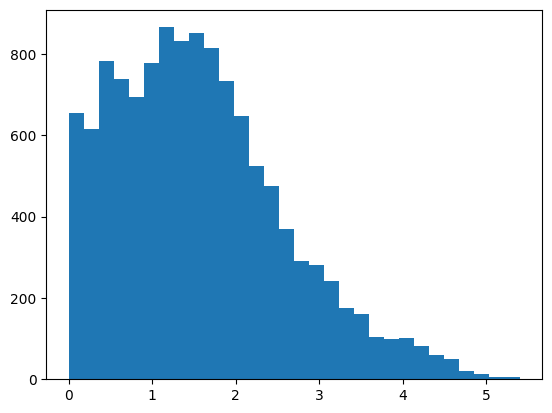

In [255]:
def clean(df: pd.DataFrame, min_val=0, max_val=100):
    print('Length of data frame:', len(df))
    df = df[(df.revenue > min_val) & (df.revenue < max_val)]
    print('Length after removing extreme values and zero revenue retail stores:',  len(df))
    plt.hist(np.log1p(train.revenue), 30)
    plt.show()
    return df.drop(columns=['revenue']), df.revenue


def clean_out_nan_heavy_rows(df: pd.DataFrame):
    """Cleans out rows that have no match in the age, spatial, income or household datasets."""

    df2 = df.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')
    df2 = df2.merge(spatial_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(income_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(households_2016.drop(columns=['year']), on='grunnkrets_id', how='left')

    df_cleaned = df[
        ~(df2.age_0_19.isna() | df2.couple_children_0_to_5_years.isna() | df2.grunnkrets_name.isna() | df2.income_all_households.isna())  
    ]

    print(f'Cleaned out {len(df) - len(df_cleaned)} out of {len(df)} rows.')

    return df_cleaned


train = clean_out_nan_heavy_rows(train)
label_name = 'revenue'
X = train.drop(columns=[label_name])
y = train[label_name]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8) # , random_state=SEED
X_train, y_train = clean(pd.merge(X_train, y_train, left_index=True, right_index=True))

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

In [ ]:
def clean(df: pd.DataFrame, min_val=0, max_val=100):
    print('Length of data frame:', len(df))
    df = df[(df.revenue > min_val) & (df.revenue < max_val)]
    print('Length after removing extreme values and zero revenue retail stores:',  len(df))
    plt.hist(np.log1p(train.revenue), 30)
    plt.show()
    return df.drop(columns=['revenue']), df.revenue


def clean_out_nan_heavy_rows(df: pd.DataFrame):
    """Cleans out rows that have no match in the age, spatial, income or household datasets."""

    df2 = df.merge(group_ages(age, age_ranges), on='grunnkrets_id', how='left')
    df2 = df2.merge(spatial_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(income_2016.drop(columns=['year']), on='grunnkrets_id', how='left')
    df2 = df2.merge(households_2016.drop(columns=['year']), on='grunnkrets_id', how='left')

    df_cleaned = df[
        ~(df2.age_0_19.isna() | df2.couple_children_0_to_5_years.isna() | df2.grunnkrets_name.isna() | df2.income_all_households.isna())  
    ]

    print(f'Cleaned out {len(df) - len(df_cleaned)} out of {len(df)} rows.')

    return df_cleaned


train = clean_out_nan_heavy_rows(train)
label_name = 'revenue'
X = train.drop(columns=[label_name])
y = train[label_name]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8) # , random_state=SEED
X_train, y_train = clean(pd.merge(X_train, y_train, left_index=True, right_index=True))

y_train = np.log1p(y_train)
y_val = np.log1p(y_val)

# Feature generation

In [256]:
def generate_features(df: pd.DataFrame, data_origin: str, predictor: str = ''):
    # Define datasets to be merged
    age_groups_merge = group_ages(age, age_ranges)
    spatial_merge = spatial_2016.drop(columns=['year'])
    income_merge = income_2016.drop(columns=['year'])
    households_merge = households_2016.drop(columns=['year'])
    plaace_merge = plaace.drop_duplicates(subset='plaace_hierarchy_id')
    bus_data_train_merge = gpd.read_parquet(f'derived_data/stores_bus_stops_lt_1km_{data_origin}').drop(columns=['geometry'])
    stores_vicinity_merge = gpd.read_parquet(f'derived_data/stores_count_lt_1km_{data_origin}').drop(columns=['geometry'])

    # Merge datasets
    df = df.merge(age_groups_merge, on='grunnkrets_id', how='left')
    df = df.merge(spatial_merge, on='grunnkrets_id', how='left')
    df = df.merge(muni_avg_revenue, on='municipality_name', how='left')
    df = df.merge(income_merge, on='grunnkrets_id', how='left')
    df = df.merge(households_merge, on='grunnkrets_id', how='left')
    df = df.merge(plaace_merge, how='left')
    df = df.merge(bus_data_train_merge, on='store_id', how='left')
    df = df.merge(stores_vicinity_merge, on='store_id', how='left')
    df = add_city_centre_dist(df).drop(columns=['lon_center', 'lat_center'])

    # #Impute NaNs from spatial
    # if sum(df["grunnkrets_name"].isnull()):
    #     df["grunnkrets_name"].fillna("Ukjent grunnkrets")

    # Transformations
    df.stores_count_lt_1km = df.stores_count_lt_1km.apply(np.log)

    # Handle categories for different predictors
    if predictor == 'xgb':
        # df = to_categorical(df)
        df = object_encoder(df)
    elif predictor == 'catboost':
        df = nan_to_string(df)
    else: 
        raise ValueError('Invalid predictor')

    features = [
        'store_name', 
        'mall_name', 
        'chain_name',
        'address', 
        'lat', 'lon',
        
        *age_groups_merge.drop(columns=['grunnkrets_id']).columns,
        *income_merge.drop(columns=['grunnkrets_id']).columns,
        *households_merge.drop(columns=['grunnkrets_id']).columns,
        'lv1_desc', 'lv2_desc', 'sales_channel_name',
        *bus_data_train_merge.drop(columns=['store_id']).columns,
        *stores_vicinity_merge.drop(columns=['store_id']).columns,
        'dist_to_center'
    ]

    return df[features]

In [257]:
def plot_corr(data):
  df = data[['revenue', 
    # 'age_0_19', 'age_20_39', 'age_40_59', 'age_60_79', 'age_80_90', 
    # 'bus_stops_count', 'Mangler viktighetsnivå', 'Standard holdeplass', 'Lokalt knutepunkt', 'Nasjonalt knutepunkt', 'Regionalt knutepunkt', 'Annen viktig holdeplass', 
    'dist_to_center', 'lat','lon'
    ]]
  df['knutepunkt'] = data[['Lokalt knutepunkt', 'Nasjonalt knutepunkt', 'Regionalt knutepunkt']].sum(axis=1)
  # df.revenue = np.exp(df.revenue)
  # df.bus_stops_count = np.sqrt(df.bus_stops_count)
  df = df[df.dist_to_center < 70_000]
  # df.dist_to_center = np.log(df.dist_to_center)
  
  plt.figure(figsize=(15, 15))
  pairplot = sns.pairplot(df)
  # heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)


# data_full =  pd.merge(X_train, y_train, left_index=True, right_index=True) 
# plot_corr(data_full)


In [258]:
def clear_buffers(X_train, y_train, X_val, y_val):
    # Clear buffers
    folder = os.path.join(os.getcwd(), 'modeling')

    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isfile(file_path):
            os.unlink(file_path)
            print(f'Deleted file: {file_path}')

    train_buffer_path = 'modeling/train.buffer'
    test_buffer_path = 'modeling/test.buffer'

    dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
    dtrain.save_binary(train_buffer_path)
    print(f'--> {train_buffer_path} created and saved.')

    dvalid = xgb.DMatrix(data=X_val, label=y_val, enable_categorical=True)
    dvalid.save_binary(test_buffer_path)
    print(f'--> {test_buffer_path} created and saved.')

    return dtrain, dvalid

In [259]:
# print(model.best_score_)
# y_pred_train = model.predict(X_train)
# y_pred_val = model.predict(X_val)
# print(rmsle(y_train, y_pred_train))
# print(rmsle(y_val, y_pred_val))

In [260]:
def train_xgb_model(X_train, y_train, X_val, y_val):
    params = {'colsample_bytree': 0.7717138210314867, 'learning_rate': 0.047506668950627134, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 223, 'subsample': 0.9929036803032936}
    print('Clearing and creating buffers...')
    dtrain, dvalid = clear_buffers(X_train, y_train, X_val, y_val)
    
    rand_search_model = random_k_fold(X_train, y_train, verbose=1, n_iter=100)
    model = rand_search_model
    params = model.best_params_
    print(rand_search_model.best_score_, params)
    
    # params = {'colsample_bytree': 0.8601277878899238, 'eval_metric': 'rmsle', 'gamma': 0.12760202929262826, 'learning_rate': 0.07356461924449906, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 306, 'objective': 'reg:squaredlogerror', 'subsample': 0.8993341396761092}
    
    params['disable_default_eval_metric'] = True
    # model = XGBRegressor()
    # model.set_params(**params)
    # model.fit(X_train, y_train)
    # y_pred_train = model.predict(X_train)
    # y_pred_val = model.predict(X_val)
    # print(rmsle(y_train, y_pred_train))
    # print(rmsle(y_val, y_pred_val))

    # num_round = 999
    # watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    # print("Attempting to start training...")
    # model = xgb.train(
    #     params=params, 
    #     dtrain=dtrain, 
    #     num_boost_round=num_round, 
    #     evals=watchlist, 
    #     early_stopping_rounds=10, 
    #     verbose_eval=20)
    # print("--> model trained.")
    # print('Best score:', model.best_score)

    # print("Attempting to save model...")
    # model.save_model(model_name)
    # print("--> model saved.")

    return model


# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8)
# X_train, X_val = generate_features(X_train, predictor='xgb'), generate_features(X_val, predictor='xgb')

# model = train_xgb_model(X_train, y_train, X_val, y_val)

In [261]:
# y_pred_train = model.predict(X_train)
# y_pred_val = model.predict(X_val)
# print(rmsle(y_train, y_pred_train))
# print(rmsle(y_val, y_pred_val))

In [262]:
def xgb_prediction(X_test, model):
    dtest = xgb.DMatrix(data=X_test, enable_categorical=True)

    print("\nAttempting to start prediction...")
    y_pred = model.predict(dtest, ntree_limit=model.best_iteration)
    print("--> Prediction finished.")

    print("\nAttempting to save prediction...")
    submission['predicted'] = np.array(y_pred)
    submission.to_csv('submissions/submission.csv', index=False)
    print("--> prediction saved with features as name in submission folder.")


# X_test = generate_features(test, predictor='xgb')
# xgb_prediction(X_test, model)

In [263]:
# xgb_model = model.best_estimator_ if model.best_estimator_ is not None else model
# xgb_model = model
# plot_importance(xgb_model)
# xgb.to_graphviz(xgb_model, num_trees=1)

### Prepare features for Catboost predictor

In [264]:
X_train = generate_features(X_train, data_origin='train', predictor='catboost')
X_val = generate_features(X_val, data_origin='train', predictor='catboost')
X_test = generate_features(test, data_origin='test', predictor='catboost')

# auxillary_columns = ['address']
text_features = ['store_name', 'address', 'sales_channel_name'] 
cat_features = ['mall_name', 'chain_name', 'lv1_desc', 'lv2_desc']

X_train.to_csv('xtrain.csv', index=False)
train_pool = cb.Pool(
    X_train,
    y_train,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)

valid_pool = cb.Pool(
    X_val,
    y_val,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)

In [265]:
from catboost.utils import get_gpu_device_count

gpu_count = get_gpu_device_count()

non_tunable_params = {
    'objective': 'RMSE',
    'eval_metric': 'RMSE',
    'task_type': 'GPU' if gpu_count else 'CPU', 
    'devices': f'0:{gpu_count}',
    'random_seed': SEED
}

def objective(trial: optuna.Trial) -> float:
    tunable_params = {
        'depth': trial.suggest_int('depth', 4, 9),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        # 'iterations': trial.suggest_int('iterations', 1000, 2000),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 6),
        # 'learning_rate': trial.suggest_categorical('learning_rate', 0.1, 0.5)
    }

    kmeans_param = {
        'clusters': trial.suggest_int('clusters', 10, 50),
        'filter': trial.suggest_categorical('filter', ['lv1_desc', 'lv2_desc', False])
    }
    
    kmeans = generate_kmeans(X_train_extra, **kmeans_param)
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8)
    X_train, X_val = generate_features(X_train, predictor='catboost'), generate_features(X_val, predictor='catboost')
    X_train, X_val = predict_kmeans(X_train, kmeans, **kmeans_param), predict_kmeans(X_val, kmeans, **kmeans_param)
    y_train, 
    train_pool = cb.Pool(
        X_train,
        y_train,
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )

    valid_pool = cb.Pool(
        X_val,
        y_val,
        cat_features=cat_features,
        text_features=text_features,
        feature_names=list(X_train)
    )

    if param['bootstrap_type'] == 'Bayesian': 
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1, log=True)

    cbr = cb.CatBoostRegressor(**param, task_type='CPU', devices='0:1')
    
    # pruning_callback = optuna.integration.CatBoostPruningCallback(trial, 'LogTargetsRmsleMetric')
    if tunable_params['bootstrap_type'] == 'Bayesian': 
        tunable_params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif tunable_params['bootstrap_type'] == 'Bernoulli':
        tunable_params['subsample'] = trial.suggest_float('subsample', 0.1, 1, log=True)

    cbr = cb.CatBoostRegressor(**non_tunable_params, **tunable_params, early_stopping_rounds=100) 
    cbr.fit(
        train_pool,
        eval_set=[(X_val, y_val)],
        verbose=True,
        early_stopping_rounds=50,
    )

    y_pred = cbr.predict(X_val)
    score = rmsle(np.expm1(y_val), np.expm1(y_pred))

    return score


def tuned_hyperparameters():
    study = optuna.create_study(
        study_name='catboost-tuning',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), 
        direction='minimize'
    )
    study.optimize(objective, n_trials=100, timeout=900) 

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('Value:', trial.value)
    print('Params:')
    print(trial.params)

    return trial.params


tuned_params = tuned_hyperparameters()

[I 2022-11-10 14:45:17,771] A new study created in memory with name: catboost-tuning
[I 2022-11-10 14:45:20,205] Trial 0 finished with value: 0.7469178460422802 and parameters: {'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 5.436679790271348}. Best is trial 0 with value: 0.7469178460422802.
[I 2022-11-10 14:45:29,245] Trial 1 finished with value: 0.7414257482100703 and parameters: {'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'l2_leaf_reg': 4.580319521572814}. Best is trial 1 with value: 0.7414257482100703.
[I 2022-11-10 14:45:42,418] Trial 2 finished with value: 0.730993164857532 and parameters: {'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'l2_leaf_reg': 4.583260076570088, 'subsample': 0.10653078706404248}. Best is trial 2 with value: 0.730993164857532.
[I 2022-11-10 14:45:50,030] Trial 3 finished with value: 0.7242331576335475 and parameters: {'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bern

In [ ]:
# Slower, but due to an issue with Catboost, training on the CPU often yields a better result than on the GPU 
# non_tunable_params['task_type'] = 'CPU'

# tuned_params = {'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.03251749341592476}

model = cb.CatBoostRegressor(**non_tunable_params, **tuned_params, iterations=1000)
model.fit(train_pool, eval_set=valid_pool, verbose=50, plot=True, early_stopping_rounds=100)

y_pred = np.expm1(model.predict(X_test))
submission['predicted'] = y_pred
submission.to_csv('submissions/submission.csv', index=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.079324
0:	learn: 0.9912538	test: 1.0034499	best: 1.0034499 (0)	total: 7.39ms	remaining: 7.38s
50:	learn: 0.7350948	test: 0.7579707	best: 0.7579707 (50)	total: 358ms	remaining: 6.67s
100:	learn: 0.7147583	test: 0.7459337	best: 0.7459337 (100)	total: 659ms	remaining: 5.86s
150:	learn: 0.6985188	test: 0.7401003	best: 0.7401003 (150)	total: 896ms	remaining: 5.04s
200:	learn: 0.6844212	test: 0.7381145	best: 0.7380096 (196)	total: 1.13s	remaining: 4.48s
250:	learn: 0.6725409	test: 0.7365665	best: 0.7363875 (242)	total: 1.35s	remaining: 4.04s
300:	learn: 0.6628646	test: 0.7349469	best: 0.7349469 (300)	total: 1.58s	remaining: 3.67s
350:	learn: 0.6546900	test: 0.7340060	best: 0.7338998 (346)	total: 1.81s	remaining: 3.34s
400:	learn: 0.6469499	test: 0.7335009	best: 0.7335009 (400)	total: 2.04s	remaining: 3.04s
450:	learn: 0.6394161	test: 0.7325660	best: 0.7325660 (450)	total: 2.27s	remaining: 2.76s
500:	learn: 0.6322389	test: 0.7325239	best: 0.7322076 (480)	total: 2.51s	re

Text(0.5, 1.0, 'Feature Importance')

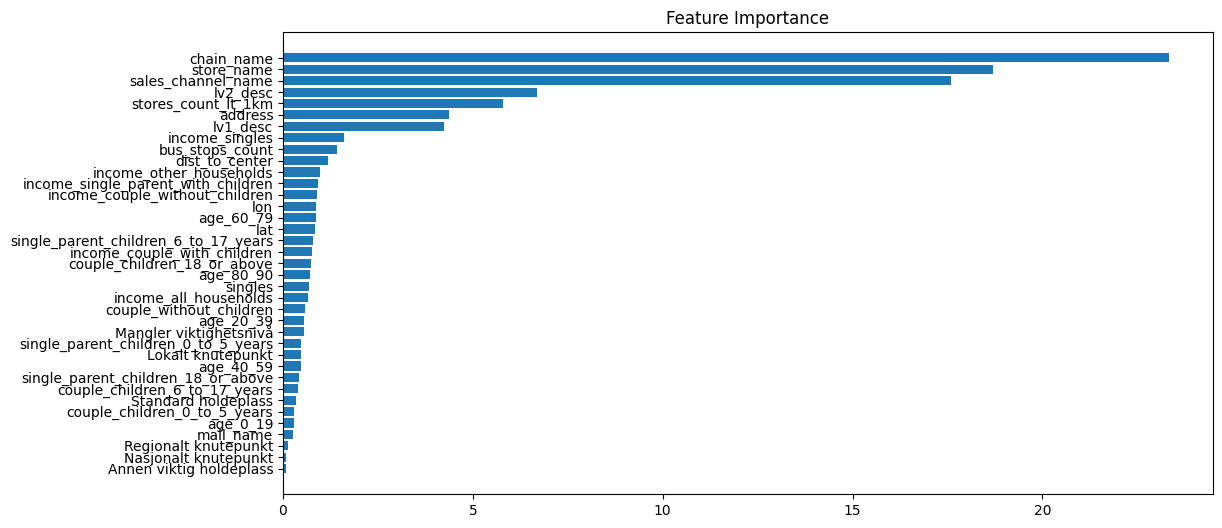

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
model.save_model(f'models/{model.best_score_["validation"]["RMSE"]:.5f}')

In [ ]:
loaded_model = cb.CatBoostRegressor(**non_tunable_params, **tuned_params, iterations=1000).load_model('models/0.71681')
y_pred = np.expm1(loaded_model.predict(X_val))
print(rmsle(np.expm1(y_val), y_pred))

y_pred_test = np.expm1(model.predict(X_test))
submission['predicted'] = y_pred_test
submission.to_csv('submissions/submission.csv', index=False)


0.6528260350326687
